In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import requests
import datetime as dt
%matplotlib inline

Call in results from API

In [2]:
headers = {'X-App-Token':SF_DATA_APP_TOKEN}
response = requests.get('https://data.sfgov.org/resource/nfpa-mg4g.json', headers=headers)
tests = pd.DataFrame(response.json())

In [3]:
response

<Response [200]>

In [4]:
tests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   specimen_collection_date  202 non-null    object
 1   tests                     202 non-null    object
 2   pos                       202 non-null    object
 3   pct                       202 non-null    object
 4   neg                       202 non-null    object
 5   indeterminate             202 non-null    object
 6   last_updated_at           202 non-null    object
dtypes: object(7)
memory usage: 11.2+ KB


Format the dates, throwing away the time (all zeros anyway)

In [5]:
tests.specimen_collection_date = pd.to_datetime(tests.specimen_collection_date.str[:10], format='%Y-%m-%d')
tests.last_updated_at = pd.to_datetime(tests.last_updated_at.str[:10], format='%Y-%m-%d')

Format the other numbers

In [6]:
tests.loc[:,'tests':'indeterminate'] = tests.loc[:,'tests':'indeterminate'].astype(float)

In [7]:
tests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   specimen_collection_date  202 non-null    datetime64[ns]
 1   tests                     202 non-null    float64       
 2   pos                       202 non-null    float64       
 3   pct                       202 non-null    float64       
 4   neg                       202 non-null    float64       
 5   indeterminate             202 non-null    float64       
 6   last_updated_at           202 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(5)
memory usage: 11.2 KB


5 day average

In [8]:
five_day = tests.sort_values('specimen_collection_date')[-5:]
five_day

,specimen_collection_date,tests,pos,pct,neg,indeterminate,last_updated_at
197,2020-09-13,1909.0,27.0,0.014181,1877.0,5.0,2020-09-17
198,2020-09-14,3724.0,90.0,0.024194,3630.0,4.0,2020-09-17
199,2020-09-15,3416.0,58.0,0.016989,3356.0,2.0,2020-09-17
200,2020-09-16,1542.0,24.0,0.015574,1517.0,1.0,2020-09-17
201,2020-09-17,20.0,4.0,0.200000,16.0,0.0,2020-09-17


In [9]:
prev = five_day.pos.sum() / five_day.tests.sum()
round(prev * 100, 2)

1.91

Sort by date

In [10]:
tests = tests.sort_values(by='specimen_collection_date')

Can work on a copy (for example: to drop most recent date id volume of tests is currently low)

In [11]:
# tests2 = tests.drop(tests.index.max()).copy() #drop most recent date
tests2 = tests #plot everything

Plot tests2

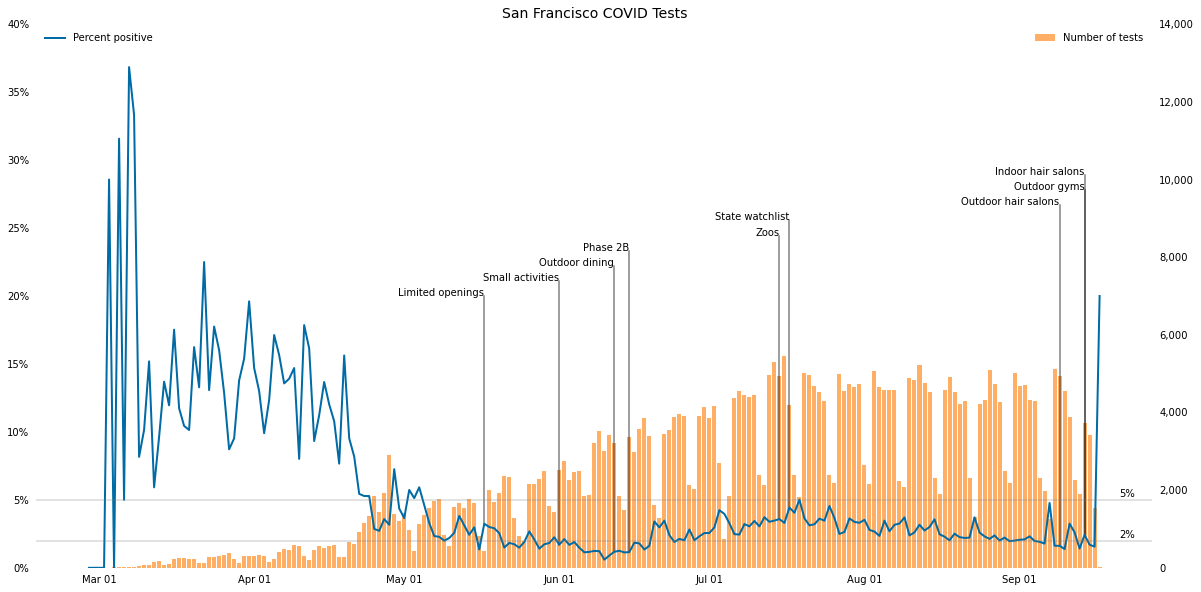

In [12]:
#master controls
#alphas------------------
bar_alpha = 0.63
line_alpha = 1
perc_lines_alpha = 0.3
key_dates_alpha = 0.5
#on or off---------------
perc_lines_on = True
key_dates__on = True
bars_on = True
#axes scales-------------
pct_scale = 0.4
tests_scale = 14000
#key_dates
key_dates = [
              ('Limited openings'                                , dt.datetime(2020, 5, 17))
             ,('Small activities'                                , dt.datetime(2020, 6, 1 ))
             ,('Outdoor dining'                                  , dt.datetime(2020, 6, 12))
             ,('Phase 2B'                                        , dt.datetime(2020, 6, 15))
             ,('Zoos'                                            , dt.datetime(2020, 7, 15))
             ,('State watchlist'                                 , dt.datetime(2020, 7, 17))
             ,('Outdoor hair salons'                             , dt.datetime(2020, 9, 9))
             ,('Outdoor gyms'                                    , dt.datetime(2020, 9, 14))
             ,('Indoor hair salons'                              , dt.datetime(2020, 9, 14))
            ]
#perc_lines
perc_lines = [
               2
              ,5
#               ,8
             ]

#set both axes
fig, ax = plt.subplots(figsize=(20, 10))
ax2 = ax.twinx()

#scale axes
ax2.set(adjustable='box',
        ylim=(0, tests_scale))
ax.set_ylim(0, pct_scale)

#draw line and bars
ax.plot(tests2['specimen_collection_date'], tests2['pct'], color=(0/255, 107/255, 164/255, line_alpha), 
        lw=2, label='Percent positive', zorder=2) # Line chart
if bars_on == True:
    ax2.bar(tests2['specimen_collection_date'], tests2['tests'], color=(255/255, 128/255, 14/255, bar_alpha), 
            label='Number of tests', zorder=2) # Bar chart

#draw % lines
if perc_lines_on == True:
    for line in perc_lines:
        line /= 100
        ax.axhline(line, color='grey', alpha=perc_lines_alpha)
        ax.text(tests2['specimen_collection_date'].max()+dt.timedelta(days=4), 
                line+0.002, str(round(line*100))+'%')
    
# ax.axhline(0.05, color='grey', alpha=two_perc_line_alpha)
# ax.text(tests2['specimen_collection_date'].max()+dt.timedelta(days=4), 0.052, '5%')

#Draw the 2% line on top
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

#draw key-date lines
if key_dates__on == True:
    line_height = 0.5
    lines_top = 0.75
    text_space = ((lines_top-line_height)/len(key_dates))
    for name, date in key_dates:
        ax.axvline(date, ymax=line_height, color='black', alpha=key_dates_alpha, zorder=1,
                   ymin=tests2['pct'][tests2['specimen_collection_date']==date].iloc[0]/pct_scale)
        ax.text(date, line_height*pct_scale, name, ha='right')
        line_height += text_space
    
#can label axes instead of having legends
# ax2.set_ylabel('Number of tests', fontsize=11)
# ax.set_ylabel('Percent positive', fontsize=11)

# Clean up chart
for key, spine in ax.spines.items():
    spine.set_visible(False)
    
for key, spine in ax2.spines.items():
    spine.set_visible(False)

ax.tick_params(top=False, bottom=False, left=False, right=False)
ax2.tick_params(right=False)

#legends and title
ax.legend(loc=2, frameon=False)
if bars_on == True:
    ax2.legend(loc=1, frameon=False)
plt.title("San Francisco COVID Tests", fontsize=14)

#format tick labels
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

#Fix tick issue
locator = mdates.AutoDateLocator()
locator.intervald[3] = locator.intervald[3][:-1]
ax.xaxis.set_major_locator(locator)

#show it or save it
plt.savefig('SF COVID tests.png')
# plt.show()

Last five days

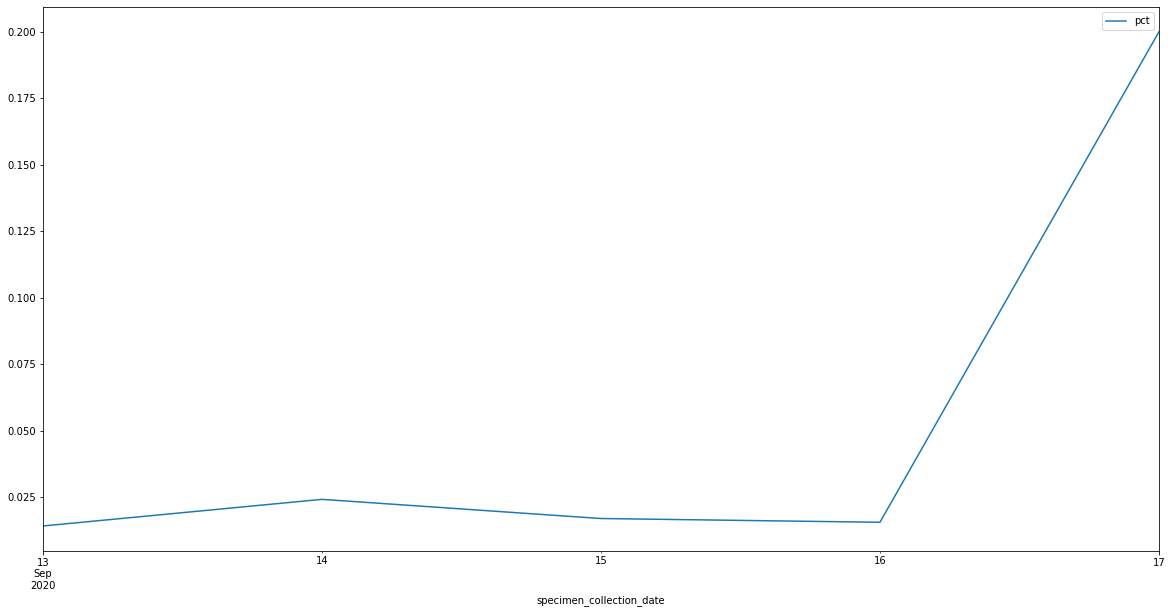

In [13]:
five_day.plot('specimen_collection_date', 'pct', figsize=(20, 10))

Last 15 days

In [14]:
tests[-15:]

,specimen_collection_date,tests,pos,pct,neg,indeterminate,last_updated_at
187,2020-09-03,4327.0,100.0,0.023159,4218.0,9.0,2020-09-17
188,2020-09-04,4297.0,84.0,0.019760,4167.0,46.0,2020-09-17
189,2020-09-05,2306.0,44.0,0.019122,2257.0,5.0,2020-09-17
190,2020-09-06,1972.0,35.0,0.017830,1928.0,9.0,2020-09-17
191,2020-09-07,1262.0,60.0,0.047733,1197.0,5.0,2020-09-17
192,2020-09-08,5120.0,83.0,0.016243,5027.0,10.0,2020-09-17
193,2020-09-09,4943.0,80.0,0.016194,4860.0,3.0,2020-09-17
194,2020-09-10,4564.0,63.0,0.013813,4498.0,3.0,2020-09-17
195,2020-09-11,3889.0,126.0,0.032474,3754.0,9.0,2020-09-17
196,2020-09-12,2271.0,59.0,0.026083,2203.0,9.0,2020-09-17


Two-week average test positivity

In [15]:
round(100 * (tests[-14:].pos.sum() / tests[-14:].tests.sum()), 1)

2.0